In [41]:
"""
Class implementing tracks, contains the list of hits, the physical information, the tangent, the x0.
The methods are the chi^2. 
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\TP4_ECAL-\\utils')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\tracking')
from hit import Hit
from parameters import *
plt.ion()
from filterpy.kalman import KalmanFilter
from track_reconstruction import coord_to_pos_z,coord_to_pos_x,coord_to_pos
from physics import overlap_length

class Track:
    def __init__(self, *args):
        """Creates a Track from arguments.
            If zero argument, then it's an empty instance
            If one argument (list of Hits), then it computes the best track using Hough transform
            If 3 arguments (list of Hits, t, x0), then it simply writes all the parameters
            
        Args:
            hits (Hit): recorded hits associated to this track
            t (float): tangent angle (0° is vertical)
            x0 (flaot): extrapolated coordinate of the crossing of the top of the box
            hits_index: index of the hits in the event when the data was recorded
        """
        self.steps = n_layers
        if len(args) == 0:
            self.hits = []
            self.t = None
            self.x0 = None
            self.n_freedom = None
            self.reduced_chi2 = None
            self.mean_time = None
            self.hits_index = None
        elif len(args) == 1:
            self.hits = args[0]
            self.n_freedom = len(self.hits) - 1 # two parameters: f(x) = a*x + b, number of data points = len + 1
            self.find_track(1, 10,False,5,0)
            self.find_track(11, 15,False,0.5,self.t)
            self.mean_time = None # TODO: implement
            if self.n_freedom > 0:
                self.reduced_chi2 = self.chi2()/self.n_freedom
            else:
                self.reduced_chi2 = np.inf
        elif len(args) == 4:
            self.hits = args[0]
            self.t = args[1]
            self.x0 = args[2]
            self.mean_time = args[3]
            self.n_freedom = len(self.hits) - 1  # two parameters: f(x) = a*x + b, number of data points = len + 1
            if self.n_freedom > 0:
                self.reduced_chi2 = self.chi2()/self.n_freedom
            else:
                self.reduced_chi2 = np.inf
            self.hits_index = [i for i in range(len(self.hits))]
        else:
            raise ValueError("not the correct number of arguments given")
        
    def keep_hits_only(self):
        """Keeps only the hits given by the hits_index
        """
        self.hits = [self.hits[i] for i in self.hits_index]
        self.n_freedom = len(self.hits) - 1
        
    def x(self, z):
        return self.t * z + self.x0
            
    def get_timestamps(self):
        """Gets the timestamps for all the hits

        Returns:
            list of float: timestamps of hits
        """
        return [hit.timestamp + hit.timestamp_event for hit in self.hits]
    
    def get_plot(self, axs):
        fit = self.get_tracks() #np.round(self.get_tracks())
        # fit = [[int(f[0]), int(f[1])] for f in fit]
        hitsX = [hit.get_pos()[0] for hit in self.hits]
        hitsZ = [hit.get_pos()[1] for hit in self.hits]
        bins_z = np.array([0])
        for i in range(16):
            bins_z = np.append(bins_z,[bins_z[-1]+thickness, bins_z[-1]+thickness_screen])
            
        axs.hist2d(hitsX, hitsZ, bins=[(np.linspace(0, 25, 26))*width, bins_z], cmap='magma')
        # axs.hist2d(hitsX, hitsZ, bins=[24, 8], range=[[1, 24], [1, 8]], cmap='magma')
        if(self.hits[0].is_sidex):
            axs.plot([coord_to_pos_x(f[0]) for f in fit], [coord_to_pos_z(f[1],True) for f in fit], 'b-')
        else:
            axs.plot([coord_to_pos_x(f[0]) for f in fit], [coord_to_pos_z(f[1],False) for f in fit], 'b-')
        plt.xticks(np.linspace(1, 24, 6)*width)
        plt.yticks(np.linspace(1, 8, 8)*(thickness_screen+thickness))
        coords_x = []
        coords_z = []
        for i in self.hits_index:
            if self.hits[i].coord in fit:
                coords_x.append(self.hits[i].get_pos()[0])
                coords_z.append(self.hits[i].get_pos()[1])
        axs.plot(coords_x, coords_z, 'r*')
        axs.set(xlabel='$x$', ylabel='$z$')
        return axs

    def print(self, plot = False, ax = None):
        """Prints the relevant information (reduced chi^2, tangent angle and x0)
        """
        print("Reduced chi^2 = {:.2f}".format(self.reduced_chi2))
        print("t = {:.2f},\t x0 = {:.2f}".format(self.t, self.x0))
        if plot:
            if ax is None:
                fig, ax = plt.subplots(1, 1)     
                self.get_plot(ax)
                # fig.show()
            else:
                self.get_plot(ax)
            

    def chi2(self, tracks = None):
        """Computes the chi^2 between the hits and the track
        Returns:
            float: chi^2
        """
        hits = self.get_hits_coords()
        if tracks is None:
            tracks = self.get_tracks()
        hits.sort(key=lambda x: x[1])
        tracks.sort(key=lambda x: x[1])
        if len(hits) == 0 or len(tracks) == 0:
            return np.inf
        c = 0
        # this is necessary because the track and the hits may not begin on the same layer
        # and because there might be multiple htis in one layer
        for hit in hits:
            for track in tracks:
                if int(hit[1]) == int(track[1]):
                    c += (hit[0] - track[0])**2 / width
        return c
                
        # return np.sum([(hit[0] - track[0])**2 / width for hit, track in zip(hits, tracks)])

    
    def is_good_fit(self):
        return (self.reduced_chi2 < 3.841)
    
    def find_track(self, sampling = 10, angle_sampling = 120, plot = False, max = 5, t = 0):
        """Finds the best parameters of a track passing through the hits, can plot the recorded hits and track

        Args:
            hits (list of Hit): recorded hits
            plot (bool, optional): If a figure of the track is to be made or not. Defaults to False.

        Returns:
            x0: coordinate at the top of the box
            t: tan of the angle (0° is vertical)
            indices: indices of the hits considered
        """
        # => angle scanning between [-78.7°,78,7°]
        T = np.linspace(t-max, t+max, angle_sampling, False)
        x0s = np.empty(len(self.hits) * sampling * sampling * angle_sampling)
        txs = np.empty(len(self.hits) * sampling * sampling * angle_sampling)
        for n, hit in enumerate(self.hits):
            zs = np.linspace(hit.get_pos()[1] - 0.5*thickness, hit.get_pos()[1] + 0.5*thickness, sampling)
            xs = np.linspace(hit.get_pos()[0] - 0.5*width, hit.get_pos()[0] + 0.5*width, sampling)
            for i, z in enumerate(zs):
                for j, x in enumerate(xs):
                    index_prefix = n * sampling * sampling * angle_sampling + \
                        i * sampling * angle_sampling + j * angle_sampling
                    x0s[index_prefix:index_prefix +
                        angle_sampling] = x - T * z
                    txs[index_prefix:index_prefix + angle_sampling] = T

        H, ts, xs = np.histogram2d(txs, x0s, bins=[angle_sampling, angle_sampling])
        id_t, id_x0 = np.unravel_index(np.argmax(H, axis=None), H.shape)
        self.t = ts[id_t] + (ts[1]-ts[0])/2
        self.x0 = xs[id_x0] + (xs[1]-xs[0])/2

        fit = self.get_tracks()
        self.hits_index = self.get_indices(None, False)
        if self.n_freedom > 0:
            self.reduced_chi2 = self.chi2() / self.n_freedom
        else:
            self.reduced_chi2 = 0
        if plot:
            # fig, axs = plt.subplots(1, 2)
            fig1 = plt.figure(figsize=(10, 3), dpi = 140)
            # plt.title('$t =$ {:.2f}, $x_0 =$ {:.2f}'.format(self.t, self.x0))
            # plt.hist2d(txs, x0s, bins=int(2 * angle_sampling / maxi), cmap='inferno', range=[[self.t - 2, self.t+2], [self.x0-10, self.x0+10]])
            plt.hist2d(txs, x0s, bins = angle_sampling, cmap = 'inferno')
            plt.plot([self.t], [self.x0], 'gx', label='maximum')
            plt.xlabel('$t$')
            plt.ylabel('$x_0$')
            plt.colorbar()
            plt.legend()
            
            fig2 = plt.figure(figsize=(10, 3), dpi=140)
            # plt.title('$t =$ {:.2f}, $x_0 =$ {:.2f}'.format(self.t, self.x0))
            plt.hist2d(txs, x0s, bins=int(angle_sampling / max), cmap='inferno', range=[[self.t-1, self.t+1], [self.x0-10, self.x0+10]])
            # plt.hist2d(txs, x0s, bins=angle_sampling, cmap='inferno')
            plt.plot([self.t], [self.x0], 'gx', label='maximum')
            plt.xlabel('$t$')
            plt.ylabel('$x_0$')
            plt.colorbar()
            plt.legend()
            
            return fig1, fig2

            # hitsX = [hit.get_pos()[0] for hit in self.hits]
            # hitsZ = [hit.get_pos()[1] for hit in self.hits]
            # bins_z = np.array([0])
            # for i in range(16):
            #     bins_z = np.append(bins_z,[bins_z[-1]+thickness, bins_z[-1]+thickness_screen])
                
            # axs[1].hist2d(hitsX, hitsZ, bins=[(np.linspace(0, 25, 26))*width, bins_z], cmap='magma')
            # axs[1].plot([f[0] for f in fit], [f[1] for f in fit], 'b-')
            # axs[1].set_xticks(np.linspace(1, 24, 6)*width)
            # axs[1].set_yticks(np.linspace(1, 8, 8)*(thickness+thickness_screen))
            # axs[1].grid(True, which='major')
            # axs[1].grid(False, which='minor')
            # coords_x = []
            # coords_z = []
            # fit = np.round(self.get_tracks())
            # fit = [[int(f[0]), int(f[1])] for f in fit]
            # for i in self.hits_index:
            #     if self.hits[i].coord in fit:
            #         coords_x.append(self.hits[i].coord[0])
            #         coords_z.append(self.hits[i].coord[1])
            # axs[1].plot(coords_x, coords_z, 'r*')
            # axs[1].set(xlabel='$x$', ylabel='$z$')

        # return self.x0, self.t, self.hits_index

    def precise_track(self, plot = False):
        """Makes a very precise fit of the track, updates the angle of the object
        
        Returns:
            x0: coordinate at the top of the box
            t: tan of the angle (0° is vertical)
            indices: indices of the hits considered
        """
        self.find_track(30, 480, plot)
        self.hits_index = self.get_indices(None, False)
        self.n_freedom = len(self.hits)
        self.reduced_chi2 = self.chi2() / self.n_freedom
                
    def get_indices(self, fit_hits = None, redo_track = False):
        c = self.chi2()
        if redo_track:
            self.precise_track()
        self.hits_index = []
        if fit_hits is None:
            fit_hits = self.get_tracks()
        for t in fit_hits:
            for i, hit in enumerate(self.hits):
                if (hit.coord[0] == int(np.round(t[0]))) and (hit.coord[1] == int(np.round(t[1]))):
                    self.hits_index.append(i)
        return self.hits_index.copy()
    
    def get_tracks(self):
        """Returns a list of the coordinates of the tracks
        
        Returns:
            list of coordinates (x, z)
        """
        # return [[self.x(z), z] for z in np.linspace(1, self.steps, self.steps)] #Former version : only one x per z
        coords = []

        tol = 10**(-10)

        xmin = min(self.x0,2*self.t*n_layers*(thickness+thickness_screen)+self.x0)
        xmin = max(xmin,0)
        xmax = max(self.x0,2*self.t*n_layers*(thickness+thickness_screen)+self.x0)
        xmax = min(xmax,n_strips*width)

        coord_x_min = round(xmin//width + 1)
        coord_x_max = round(xmax//width + 1)

        z_i = []
        if (len(self.hits) > 0):
            for i in range(n_layers):
                z_center = coord_to_pos_z(i+1,self.hits[0].is_sidex)
                z_i.append([z_center-thickness/2,z_center+thickness/2])

        for j in range(coord_x_min,coord_x_max+1):
            if self.t == 0:
                z_min = 0
                z_max = 2*n_layers*(thickness+thickness_screen)
            else:
                z_max = max((coord_to_pos_x(j)-width/2-self.x0)/self.t,(coord_to_pos_x(j)+width/2-self.x0)/self.t)
                z_min = min((coord_to_pos_x(j)-width/2-self.x0)/self.t,(coord_to_pos_x(j)+width/2-self.x0)/self.t)
            for i,z in enumerate(z_i):
                if overlap_length(z,[z_min,z_max]) > tol:
                    coords.append([j,i+1])

        return coords
        
    
    def get_hits_coords(self):
        """Gets the list of coordinates of the hits

        Returns:
            list of [x, z]: coordinates of all hits
        """
        return [hit.coord for hit in self.hits]

    def get_hits_pos(self):
        """Gets the list of coordinates of the hits

        Returns:
            list of [x, z]: coordinates of all hits
        """
        return [hit.get_pos() for hit in self.hits]

    def get_time_interval(self):
        last_hit = self.hits[np.argmax(self.hits_index, axis=0)]
        if last_hit.coord[1] < 8: # because if last hit is on the last level, we don't know if it left the detector
            ## and if there are hits close to the end point
            distances = self._dr(last_hit, self.hits)
            if np.any(np.array(distances) < 2):
                return np.mean(self.get_timestamps()) - self.hits[0].timestamp_event

    def _dr(self, hit_ref, hits):
        """Computes distance between a reference hit and a list of hits

        Args:
            hit_ref (Hit): reference Hit
            hits (list of Hit): list of Hit

        Returns:
            float : distance
        """
        ## eval array of vectors connecting all hits with ref hit
        dr_u = [hit.coord[0] - hit_ref.coord[0] for hit in hits]
        dr_d = [hit.coord[1] - hit_ref.coord[1] for hit in hits]

        ## eval module
        dr_mod = [np.sqrt(dr_u[i]*dr_u[i] + dr_d[i]*dr_d[i]) for i in range(len(dr_u))]
        return dr_mod

    
    def kalman_filter(self, sigma = 1, axs = None):
        # Find starting position :
        hits = self.get_hits_coords()
        hits.sort(key = lambda x: -x[1])
        coord_init = hits[0]
        pos_init = coord_to_pos(coord_init,self.hits[0].is_sidex)

        # define the different vectors and matrices
        f = KalmanFilter(dim_x=4, dim_z=2)
        # physical state vector
        f.x = np.array([[pos_init[0]], # x
                        [pos_init[1]], # z
                        [0], # v_x
                        [-1.]]) #v_z
        #  propagation matrix
        f.F = np.array([[1., 0., Delta_z, 0.],
                        [0., 1., 0., Delta_z],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
        # measurement matrix
        f.H = np.array([[1., 0., 0., 0.],
                        [0., 1., 0., 0.]])
        # covariance matrix # TODO: find right value
        # f.P = np.array([[1., 0., 0., 0.],
        #                 [0., 1., 0., 0.],
        #                 [0., 0., 1., 0.],
        #                 [0., 0., 0., 1.]])
        f.P = np.array([[width, 0., 0., 0.],
                        [0., thickness, 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
        # measurement noise matrix
        # f.R = np.array([[width, 0.], # x
        #                 [0., thickness]]) # z
        f.R = np.array([[0.01, 0.], # x
                        [0., 0.01]]) # z
       
        #  process noise, # TODO: find right value
        d = Delta_z*(1+self.t**2)**0.5
        X_0 = 4/3*total_height
        theta = 13.6/1000*(d/X_0)**0.5*(1+0.038*np.log(d/X_0))  # Formula for mean deflection when diffusion through matter 
 
        f.Q = np.array([[theta**2*d**2, 0., theta**2*d, 0.],
                        [0., theta**2*d**2, 0., theta**2*d],
                        [theta**2*d, 0., theta**2, 0.],
                        [0., theta**2*d, 0., theta**2]])
        
        #iterate over the hit coordinates
        
        # for h in hits:
            # f.predict()
            # f.update(np.array(h))
        (mu, cov, _, _) = f.batch_filter(hits)
        (xs, P, K, Pp) = f.rts_smoother(mu, cov)
        kalman_hits = [[coord_to_pos_x(int(np.round(x[0]))), coord_to_pos_z(int(np.round(x[1])),self.hits[0].is_sidex)] for x in xs]
        fit = self.get_tracks()
        
        self.n_freedom = len(kalman_hits)
        self.reduced_chi2 = self.chi2(tracks=kalman_hits) / self.n_freedom
        
        return kalman_hits
        # if axs is not None:
        #     # fig, axs = plt.subplots(1, 1)
        #     hitsX = [hit.coord[0] for hit in self.hits]
        #     hitsZ = [hit.coord[1] for hit in self.hits]
        #     axs.hist2d(hitsX, hitsZ, bins=[-0.5 + np.linspace(0, 25, 26), -0.5 + np.linspace(0, 9, 10)], cmap='magma')
        #     axs.plot([f[0] for f in kalman_hits], [f[1] for f in kalman_hits], 'r--', label = 'Kalman')
        #     axs.plot([f[0] for f in fit], [f[1] for f in fit], 'b-', label = 'Hough')
        #     plt.xticks(np.linspace(1, 24, 6))
        #     plt.yticks(np.linspace(1, 8, 8))
        #     axs.set(xlabel='$x$', ylabel='$z$')
        #     axs.legend()
        # indices = self.get_indices(fit, False)
        
    '''
    def kalman_filter(self, sigma = 1):
            # define the different vectors and matrices
        f = KalmanFilter(dim_x=2, dim_z=2)
        # physical state vector
        f.x = np.array([[0.],  # x
                        [1.]]) # t
        #  propagation matrix
        f.F = np.array([[1., 2*(thickness+thickness_screen)],
                        [0., 1.]])
        # measurement matrix
        f.H = np.array([[1., 0.], 
                        [0., 0.]])
        # covariance matrix # TODO: find right value
        f.P = np.array([[(width/2)**2, 0.],
                        [0., 1.]])
        # measurement noise matrix
        f.R = np.array([[(width/2)**2, 0.],
                        [0., 1.]]) # z
        #  process noise, # TODO: find right value
        f.Q = np.array([[0., 0.],
                        [0., 0.]])
        
        #iterate over the hit coordinates
        hits = self.get_hits_pos()
        hits.sort(key = lambda x: x[1])
        # for h in hits:
            # f.predict()
            # f.update(np.array(h))
        (mu, cov, _, _) = f.batch_filter(hits)
        (xs, P, K, Pp) = f.rts_smoother(mu, cov)
        kalman_hits = [[x[0], x[1]] for x in xs]
        # fit = self.get_tracks()
        return kalman_hits
        '''

In [42]:
# track3D
import numpy as np
import matplotlib.pyplot as plt
from track import Track

class Track3D:
    def __init__(self, *args):
        """Creates a 3D Track class, containing two 2D tracks
        """
        if len(args) == 0:
            self.x = None
            self.y = None
            self.time = None
        elif len(args) == 1:
            hitsX = [hit for hit in args[0] if hit.is_sidex]
            hitsY = [hit for hit in args[0] if not hit.is_sidex]
            self.x = Track(hitsX)
            self.y = Track(hitsY)
            self.time = self.x.get_timestamps() + self.y.get_timestamps()
        elif len(args) == 2:
            self.x = args[0]
            self.y = args[1]
            self.time = self.x.get_timestamps() + self.y.get_timestamps()
    def get_time_stamps(self):
        ret = []
        for hit in self.x.hits:
            ret.append(hit.timestamp)
        for hit in self.y.hits:
            ret.append(hit.timestamp)
        return ret
            
    def get_time_interval(self):
        """Get the timings of all hits, returns None if zero hits are associated to the track
        
        Return:
            self.time (List of float): timestamps of hits
        """
        self.time = np.concatenate([self.x.get_timestamps(), self.x.get_timestamps()])
        hits = self.x.hits + self.y.hits
        hits_indices = self.x.hits_index + self.y.hits_index
        if len(hits_indices) > 0:
            last_hit = hits[np.argmax(hits_indices, axis = 0)]
            if last_hit.coord[1] < 8:
                distances = self.x._dr(last_hit, hits)
                if np.any(np.array(distances) < 2):
                    return np.mean(self.time) - hits[0].timestamp_event
        else:
            return None
        
    def precise_track(self):
        self.x.precise_track()
        self.y.precise_track()
        
    def find_track(self, sampling = 10, angle_sampling = 240):
        self.x.find_track(sampling, angle_sampling)
        self.y.find_track(sampling, angle_sampling)
        
    def is_good_2D_fit(self):
        return (self.x.is_good_fit() and self.y.is_good_fit())
    
    def reduced_chi2(self):
        return self.x.reduced_chi2 + self.y.reduced_chi2
    
    def print(self, plot = False, size = (12, 6)):
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(size)
        self.x.print(plot, axs[0])
        self.y.print(plot, axs[1])
        return fig
        # fig.show()
        # fig.savefig('test.png')
        
    def kalman_filter(self, sigma = 0.5, plot = False):
        if plot:
            fig, axs = plt.subplots(1, 2)
            fig.set_size_inches(12, 6)
            self.x.kalman_filter(sigma, axs[0])
            self.y.kalman_filter(sigma, axs[1])
        else:
            self.x.kalman_filter(sigma)
            self.y.kalman_filter(sigma)


In [46]:
# load and filter data

import sys
import time
tic = time.time() 
from data_loading import *
from tqdm import tqdm
from matplotlib import pyplot as plt
from track_reconstruction import *

file_path = 'C:\\Users\\Pascal\\Desktop\\TP4a\\data\\run_000002\\data_0000.root' 
import pandas as pd
import uproot
import numpy as np


N_cons_events = 10000 # number of events to consider

br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'evt_flags']
evt_tree = 'event_data;1'
hits_tree = 'event_data;1'

with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
df_evts = pd.DataFrame.from_dict(evts_dict)
df_hits = pd.DataFrame.from_dict(hits_dict)
df_hits['timestamp_event'] = df_evts['timestamp']
df_hits = df_hits[0:N_cons_events]

og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))



selected 51.92% of all events


In [47]:
# create tracks
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)

            ## check if track has a "good" chi2 value
            if track.is_good_2D_fit():
            
                # worth making a precise track
                #track.precise_track()
                
                ## compute the time of the track
                dt = track.get_time_interval()
                if dt is not None:
                    dts.append(dt)


    return tracks, dts
    

In [48]:
import time
t = time.time()
trackss, dts = create_tracks(df_hits[0:2000])
print("Average track creation time : ", 1000*(time.time()-t)/len(df_hits),"ms")

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:39<00:00, 50.44it/s]

Average track creation time :  7.644314841239589 ms


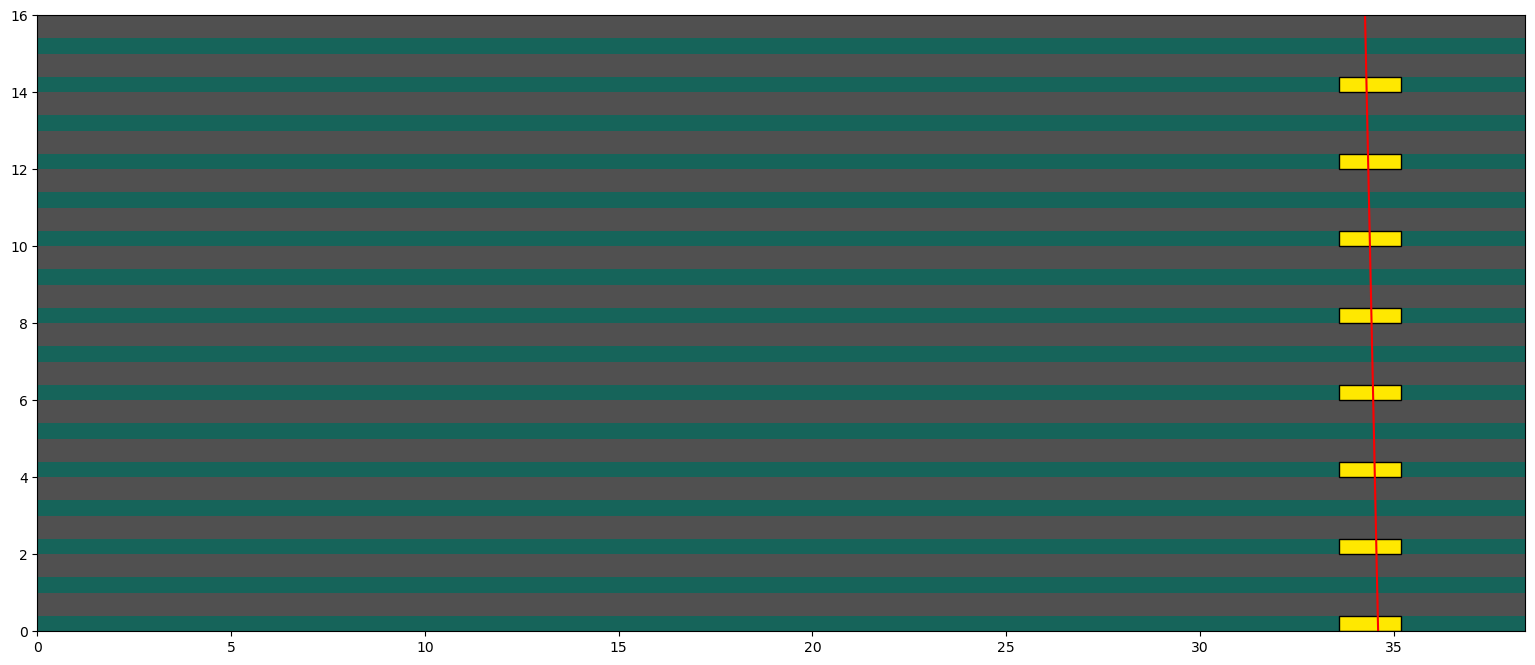

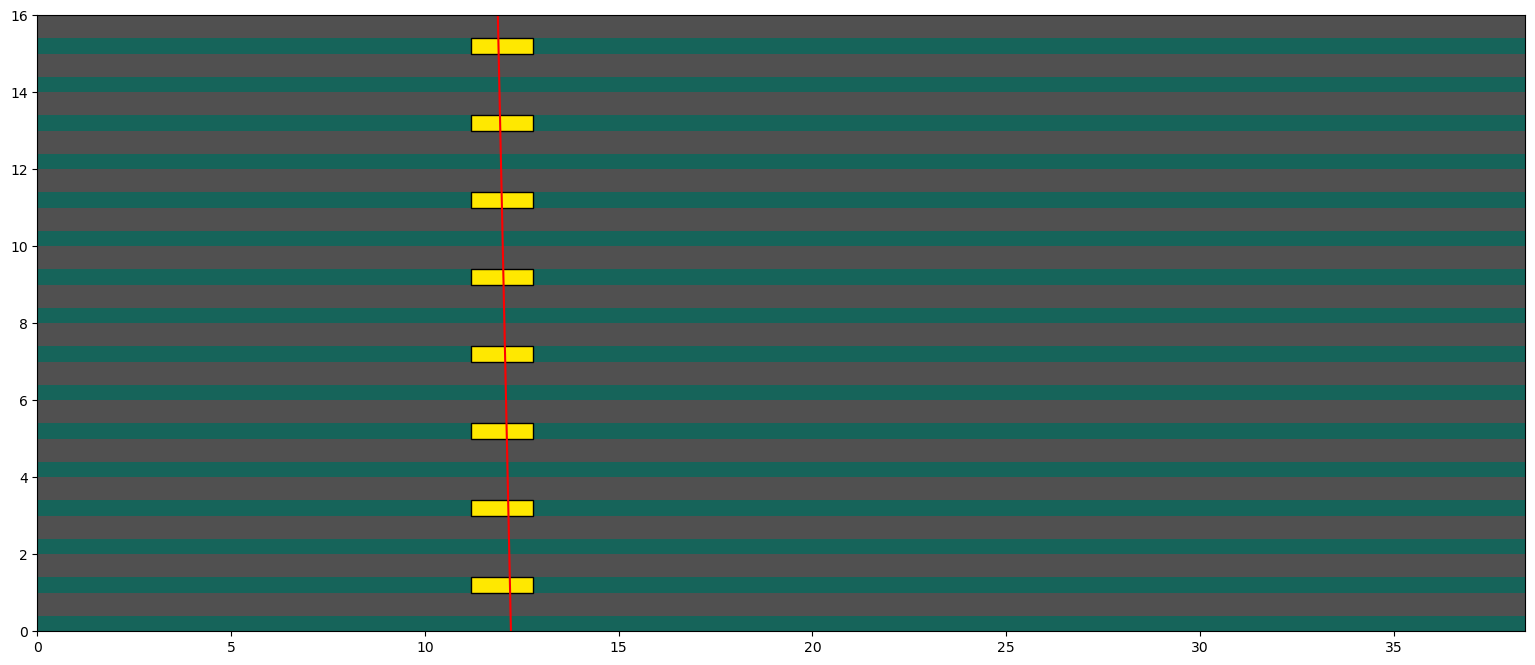

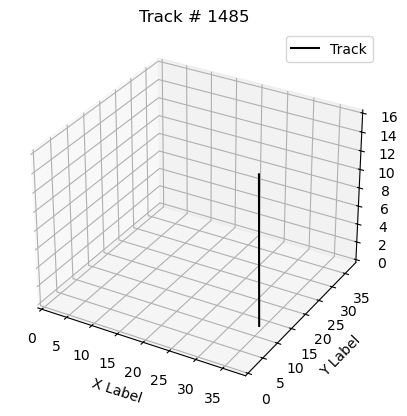

In [50]:
good_tracks = [t for t in trackss if t.is_good_2D_fit()]
ID = np.random.randint(0, len(good_tracks))
t1 = good_tracks[1460]
tt_x = t1.x
tt_y = t1.y
hitst1 = tt_x.hits
hitst2 = tt_y.hits


fig, axs=plot_hits(hitst1,True)
z = np.linspace(0,16,500)
x = tt_x.x(z)
axs.plot(x,z,'r-')
fig, axs=plot_hits(tt_y.hits,False)
y = tt_y.x(z)
axs.plot(y,z,'r-')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create some sample data for the line

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the line in 3D
ax.plot(x, y, z, 'k',label='Track')
ax.set_title('Track # {}'.format(ID))

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# Set custom axis limits
ax.axis('equal')
ax.set_xlim(0, 38.4)  # Set limits for the X axis
ax.set_ylim(0, 38.4)  # Set limits for the Y axis
ax.set_zlim(0, 16)  # Set limits for the Z axis
# Add a legend
ax.legend()

# Show the plot
plt.show()

Text(0, 0.5, '$\\theta_y$')

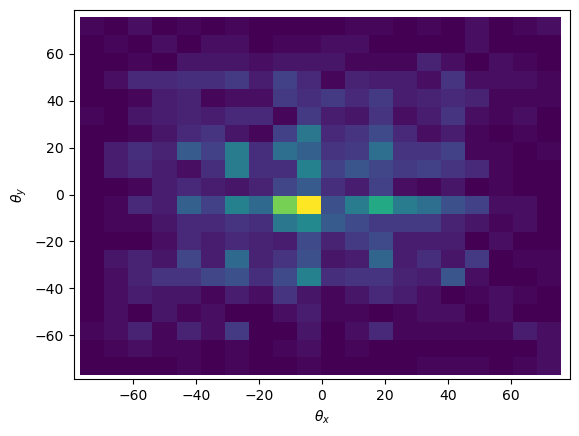

In [32]:
def time_correction(T3D):
    Speed_In_Fiber = 15 # cm/ns
    Tx = T3D.x
    Ty = T3D.y
    
    newx = []
    newy = []
    for h in Tx.hits:
        newx.append(Hit(h.get_pos(),True,h.timestamp - Ty.x(h.get_pos()[1])/Speed_In_Fiber,0,0))
    for h in Ty.hits:
        newy.append(Hit(h.get_pos(),True,h.timestamp - Tx.x(h.get_pos()[1])/Speed_In_Fiber,0,0))
    Txprime = Track(newx)
    Typrime = Track(newy)

    return Track3D(Txprime,Typrime)

In [33]:
stamps = []
for t1 in good_tracks:
    t = time_correction(t1)
    stamps = stamps+t1.get_time_stamps()

1720


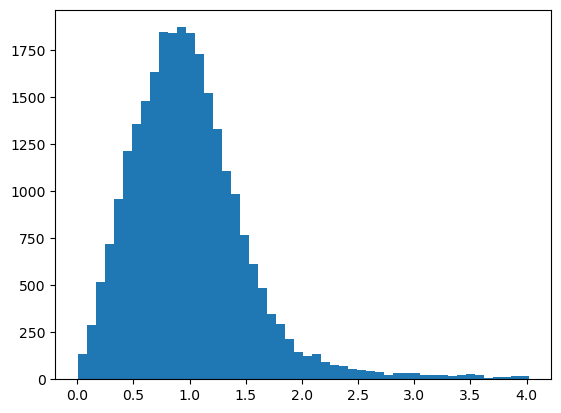

In [35]:
plt.figure()
plt.hist(stamps,50)
print(len(good_tracks))

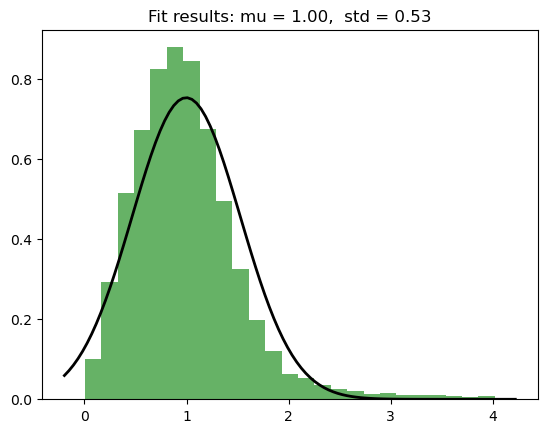

0.99684495 0.5291633


In [71]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

mu, std = norm.fit(stamps)

plt.hist(stamps, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

print(mu, std)